## Importing relevant libraries

In [96]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [97]:
data = pd.read_csv("winequality.csv")
df = data.copy()
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [98]:
# we will explore our unique values in ou predictour target fetaure which is qualit
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

Our goal is to 1) seprate the data from the wine samples,
2) group them into clusters according to their quality grade

In [99]:
#Let's standradize the data as the data have a wide range in terms of value for each column
scaler = StandardScaler()

In [100]:
x=df.iloc[:,0:11].values
y=df.iloc[:,11].values
x_std = scaler.fit_transform(x)

In [101]:
print(y)

[5 5 5 ... 6 5 6]


## Calculating the class mean

In [102]:
# The mean for each seperate quality grade of wine
np.set_printoptions(precision=1) # precision set to one to show each point close to the first decimal number 

mean_vectors=[] # to store our mean vectors that will result
for i in range(3,9): # a for loop for values in array y 
    mean_vectors.append(np.mean(x_std[y==i], axis=0)) #using np.mean to find the class mean for each value interation in y set
    print("Mean Vector quality %s :%s\n"%(i, mean_vectors[i-3])) 

Mean Vector quality 3 :[ 0.   2.  -0.5  0.1  0.7 -0.5 -0.7  0.4  0.6 -0.5 -0.4]

Mean Vector quality 4 :[-0.3  0.9 -0.5  0.1  0.1 -0.3 -0.3 -0.1  0.5 -0.4 -0.1]

Mean Vector quality 5 :[-0.1  0.3 -0.1 -0.   0.1  0.1  0.3  0.2 -0.  -0.2 -0.5]

Mean Vector quality 6 :[ 0.  -0.2  0.  -0.  -0.1 -0.  -0.2 -0.1  0.   0.1  0.2]

Mean Vector quality 7 :[ 0.3 -0.7  0.5  0.1 -0.2 -0.2 -0.3 -0.3 -0.1  0.5  1. ]

Mean Vector quality 8 :[ 0.1 -0.6  0.6  0.  -0.4 -0.2 -0.4 -0.8 -0.3  0.6  1.6]



We conclude from above for example is the Mean Vector quality 3 the second element means that the mean volitale acidity for wines graded by three is two  

## Calculating the Within- and Between-Class Scatter Matrcies

#### Clculating the within-class scatter matrix
That will help us in calculating Eigenvectors and Egienvalue of the inverse within-between matrcie,
so that we can make a fetaure selection and lower the dimension of our dataset known that within will represented as Sw and between as Sb

In [103]:
s_w =np.zeros((11, 11)) # as we have 11 features

# make the iteration process 
# note: that our goal is to calculat each covariance matrix for each seperate quality grade
# then sum these invidual class covariance matrcies up
for i,mv in zip(range(3,9), mean_vectors): # again we iterate though the quality grade and the mean vectors the idea is to calculate each covar matrix for each seperate quality grade then sum all of these
    # zip func above because we need to iterate and pair each element for new tuple 
    class_sc_mat=np.zeros((11,11))
    
    for row in x_std[y==i]:
            
        row,mv=row.reshape(11,1), mv.reshape(11,1)
        class_sc_mat+=(row-mv).dot((row-mv).T)
            
    s_w+=class_sc_mat
print('withing class-scatter matrix:\n',s_w)


withing class-scatter matrix:
 [[ 1.6e+03 -3.3e+02  1.0e+03  1.8e+02  1.7e+02 -2.3e+02 -1.4e+02  1.1e+03
  -1.1e+03  2.4e+02 -2.0e+02]
 [-3.3e+02  1.3e+03 -7.4e+02  1.1e+01  1.7e+01 -3.9e+01  2.3e+01 -6.5e+01
   3.3e+02 -2.6e+02 -4.3e+01]
 [ 1.0e+03 -7.4e+02  1.5e+03  2.2e+02  3.7e+02 -7.7e+01  1.2e+02  6.5e+02
  -8.4e+02  4.1e+02 -7.7e-01]
 [ 1.8e+02  1.1e+01  2.2e+02  1.6e+03  9.3e+01  3.1e+02  3.3e+02  5.8e+02
  -1.4e+02  1.9e-01  4.6e+01]
 [ 1.7e+02  1.7e+01  3.7e+02  9.3e+01  1.6e+03 -4.9e+00  3.4e+01  2.8e+02
  -4.3e+02  6.5e+02 -2.5e+02]
 [-2.3e+02 -3.9e+01 -7.7e+01  3.1e+02 -4.9e+00  1.6e+03  1.0e+03 -6.5e+01
   1.2e+02  1.1e+02 -3.7e+01]
 [-1.4e+02  2.3e+01  1.2e+02  3.3e+02  3.4e+01  1.0e+03  1.5e+03  3.8e+01
  -9.3e+01  1.5e+02 -1.3e+02]
 [ 1.1e+03 -6.5e+01  6.5e+02  5.8e+02  2.8e+02 -6.5e+01  3.8e+01  1.5e+03
  -5.5e+02  3.1e+02 -6.3e+02]
 [-1.1e+03  3.3e+02 -8.4e+02 -1.4e+02 -4.3e+02  1.2e+02 -9.3e+01 -5.5e+02
   1.6e+03 -3.0e+02  3.5e+02]
 [ 2.4e+02 -2.6e+02  4.1e+02  1.9

#### Clculating the Between-class scatter matrix


In [104]:
overall_mean =np.mean(x_std, axis=0)
c=0
s_b=np.zeros((11,11))
for i,mean_vec in enumerate(mean_vectors):
    n=x_std[y==i+3,:].shape[0]
    c+=1
    mean_vec=mean_vec.reshape(11,1)
    overall_mean=overall_mean.reshape(11,1)
    s_b+=n*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)
    
print('Between class scatter matrix\n',s_b)

Between class scatter matrix
 [[  30.9  -78.1   52.     6.4  -23.8  -12.6  -38.   -33.7  -13.6   52.6
    99.5]
 [ -78.1  256.6 -142.7   -7.9   81.    22.    99.4  100.7   42.5 -154.7
  -280.3]
 [  52.  -142.7   93.1   11.   -45.9  -20.2  -60.6  -63.1  -27.9   93.6
   176.5]
 [   6.4   -7.9   11.     5.3   -4.3   -7.    -8.1   -8.5   -1.5    8.7
    21.7]
 [ -23.8   81.   -45.9   -4.3   29.7   13.8   42.    40.8    9.4  -52.6
  -104.3]
 [ -12.6   22.   -20.2   -7.    13.8   23.5   46.4   30.1   -8.4  -27.7
   -73.7]
 [ -38.    99.4  -60.6   -8.1   42.    46.4  118.4   75.6  -13.2  -85.8
  -196.9]
 [ -33.7  100.7  -63.1   -8.5   40.8   30.1   75.6   64.5    5.5  -75.4
  -162. ]
 [ -13.6   42.5  -27.9   -1.5    9.4   -8.4  -13.2    5.5   21.5  -19.
   -20.8]
 [  52.6 -154.7   93.6    8.7  -52.6  -27.7  -85.8  -75.4  -19.   104.5
   204.9]
 [  99.5 -280.3  176.5   21.7 -104.3  -73.7 -196.9 -162.   -20.8  204.9
   426.4]]


### Finding egienvalues and their associated eigenvectors pairs

#### By finding the eigenvectors and ordering them by level of importance, we'll construct the linear discirminants - our new axes   

#### The new axes will comprise our lower-dimensional space onto which we'll project the data points 

In [105]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(s_w).dot(s_b))

In [106]:
eig_vals

array([ 6.3e-01+0.0e+00j,  7.6e-02+0.0e+00j,  2.5e-02+0.0e+00j,
        6.4e-03+0.0e+00j,  4.2e-03+0.0e+00j,  1.9e-17+4.2e-17j,
        1.9e-17-4.2e-17j,  1.8e-17+1.0e-17j,  1.8e-17-1.0e-17j,
       -2.7e-17+0.0e+00j, -5.7e-18+0.0e+00j])

In [107]:
eig_vecs

array([[ 2.5e-01+0.j , -4.6e-01+0.j ,  1.4e-01+0.j ,  6.9e-01+0.j ,
        -1.9e-01+0.j , -2.3e-01-0.2j, -2.3e-01+0.2j, -2.4e-01+0.1j,
        -2.4e-01-0.1j, -1.5e-01+0.j , -3.7e-01+0.j ],
       [-3.5e-01+0.j , -4.8e-01+0.j ,  3.0e-01+0.j , -1.6e-01+0.j ,
         2.6e-01+0.j ,  2.7e-02+0.1j,  2.7e-02-0.1j, -8.2e-02+0.j ,
        -8.2e-02-0.j ,  6.8e-02+0.j , -8.9e-02+0.j ],
       [-4.3e-02+0.j , -1.8e-01+0.j ,  4.3e-01+0.j , -7.3e-02+0.j ,
         3.1e-01+0.j , -9.1e-03+0.1j, -9.1e-03-0.1j,  3.5e-01-0.3j,
         3.5e-01+0.3j, -2.9e-01+0.j , -3.0e-01+0.j ],
       [ 1.3e-01+0.j , -2.3e-01+0.j ,  2.4e-01+0.j ,  1.9e-01+0.j ,
        -3.8e-01+0.j , -1.5e-02+0.3j, -1.5e-02-0.3j, -1.4e-01+0.2j,
        -1.4e-01-0.2j,  1.1e-01+0.j ,  4.6e-01+0.j ],
       [-1.9e-01+0.j , -8.0e-02+0.j , -1.4e-01+0.j ,  1.4e-01+0.j ,
         2.1e-01+0.j , -1.7e-01-0.2j, -1.7e-01+0.2j,  3.2e-01+0.2j,
         3.2e-01-0.2j, -1.7e-02+0.j ,  2.3e-01+0.j ],
       [ 9.7e-02+0.j ,  1.4e-02+0.j , -3.6e-01+0.j

#### what's left to do is to pair and sort them in a descinding order according to the eigenvalue

In [108]:
for i in range(len(eig_vals)): # for loop to interate inside eigen value elements till the last element
    eigvec_sc=eig_vecs[:,i].reshape(11,1) 
    print('\nEigenVectors {}:\n{}'.format(i+1,eigvec_sc.real)) # it could be complex numbers for eigenval and egienvac entries so we use .real func here to transpose both of them
    print('\nEigenVectors {:}:{:.2e}'.format(i+1,eig_vals[i].real))


EigenVectors 1:
[[ 0.2]
 [-0.4]
 [-0. ]
 [ 0.1]
 [-0.2]
 [ 0.1]
 [-0.3]
 [-0.2]
 [-0. ]
 [ 0.4]
 [ 0.7]]

EigenVectors 1:6.32e-01

EigenVectors 2:
[[-0.5]
 [-0.5]
 [-0.2]
 [-0.2]
 [-0.1]
 [ 0. ]
 [ 0.3]
 [ 0.5]
 [-0.4]
 [-0.1]
 [ 0.1]]

EigenVectors 2:7.64e-02

EigenVectors 3:
[[ 0.1]
 [ 0.3]
 [ 0.4]
 [ 0.2]
 [-0.1]
 [-0.4]
 [ 0.5]
 [-0.5]
 [-0.1]
 [ 0.1]
 [-0.1]]

EigenVectors 3:2.48e-02

EigenVectors 4:
[[ 0.7]
 [-0.2]
 [-0.1]
 [ 0.2]
 [ 0.1]
 [-0.1]
 [ 0.1]
 [-0.4]
 [ 0.4]
 [-0. ]
 [-0.3]]

EigenVectors 4:6.43e-03

EigenVectors 5:
[[-0.2]
 [ 0.3]
 [ 0.3]
 [-0.4]
 [ 0.2]
 [ 0.4]
 [-0.2]
 [ 0.5]
 [-0.2]
 [-0.1]
 [ 0.4]]

EigenVectors 5:4.18e-03

EigenVectors 6:
[[-0.2]
 [ 0. ]
 [-0. ]
 [-0. ]
 [-0.2]
 [-0.1]
 [-0. ]
 [ 0.4]
 [-0.1]
 [-0. ]
 [ 0.2]]

EigenVectors 6:1.87e-17

EigenVectors 7:
[[-0.2]
 [ 0. ]
 [-0. ]
 [-0. ]
 [-0.2]
 [-0.1]
 [-0. ]
 [ 0.4]
 [-0.1]
 [-0. ]
 [ 0.2]]

EigenVectors 7:1.87e-17

EigenVectors 8:
[[-0.2]
 [-0.1]
 [ 0.3]
 [-0.1]
 [ 0.3]
 [ 0.1]
 [ 0.3]
 [ 0.1]
 [

#### what still to do is we need to reorder eigenvalues in pairs from largest to smallest, this way we are arranging our new axes by level of importance 

#### we need the eigenvalues in order to find the percentage of variance carried by each of our linear discreminants (the eigenvectors)

    and to find the above we should divide each eigenvalue by the sum of all eigenvalues and multiply that by 100 Note that this will give us the precentage of variants explained by the eigenvector associated with this eigenvalue

    but we will have one issue will arise here the negative eigenvalue and the problem with this negative eigenvalue is if we tried to calculate the above ratio we will obtain a negative result for each negative eigenvalue 

so how do we solve this.?
 
    one way to fix that is to take the absloute value of the negative values ie remove the minus infront of the negative eigenvalues and insted multiplying the corresponding eigenvectors by -1 

##### Example : 
    suppose we have Matrix A and it has Eigenvalue mu = -1
    With a coressponding Eigenvector V = (1, 2)
    Av=(-1)v
    
    we can observe the equation also in this equlivant form mu = 1, v = (-1, -2)
    Let's jumpt to the code

In [109]:
# creating a list to store our values
eigen_pairs=[]

for i in range(len(eig_vals)):
    if eig_vals[i]<0:
        eigen_pairs.append((-eig_vals[i],-eig_vecs[:,i]))
    else:            
        eigen_pairs.append((eig_vals[i],eig_vecs[:,i]))            
eigen_pairs=sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

print('Evalues in descending order:\n')
for i in range (len(eigen_pairs)):
    print('Evalue:\n')
    print(eigen_pairs[i][0].real)
    print('\n')
    print('Associated evector:\n')
    print(eigen_pairs[i][1].real)
    print('\n')

Evalues in descending order:

Evalue:

0.6318983806659392


Associated evector:

[ 0.2 -0.4 -0.   0.1 -0.2  0.1 -0.3 -0.2 -0.   0.4  0.7]


Evalue:

0.07644038712342208


Associated evector:

[-0.5 -0.5 -0.2 -0.2 -0.1  0.   0.3  0.5 -0.4 -0.1  0.1]


Evalue:

0.02479746521139609


Associated evector:

[ 0.1  0.3  0.4  0.2 -0.1 -0.4  0.5 -0.5 -0.1  0.1 -0.1]


Evalue:

0.006428277646001779


Associated evector:

[ 0.7 -0.2 -0.1  0.2  0.1 -0.1  0.1 -0.4  0.4 -0.  -0.3]


Evalue:

0.0041799591450444665


Associated evector:

[-0.2  0.3  0.3 -0.4  0.2  0.4 -0.2  0.5 -0.2 -0.1  0.4]


Evalue:

2.7163343043128788e-17


Associated evector:

[ 0.2 -0.1  0.3 -0.1  0.   0.3 -0.1 -0.2  0.1 -0.8  0.2]


Evalue:

1.8740549882459568e-17


Associated evector:

[-0.2  0.  -0.  -0.  -0.2 -0.1 -0.   0.4 -0.1 -0.   0.2]


Evalue:

1.8740549882459568e-17


Associated evector:

[-0.2  0.  -0.  -0.  -0.2 -0.1 -0.   0.4 -0.1 -0.   0.2]


Evalue:

1.7658250030995973e-17


Associated evector:

[-0.2 -0.1  0.3 

## Analysis of LDA


#### Show the explained variance by each respective eigenvector  

to find the newly added soncstructed accsess significance we must add up all eigenvalues and divide each of them sepretaly by the sum to obtain the precentage of retained variance

In [110]:
print('Variance explained:\n')
eigv_sum=sum(eig_vals)
for i, j in enumerate(eigen_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0].real/eigv_sum.real)))

Variance explained:

eigenvalue 1: 84.96%
eigenvalue 2: 10.28%
eigenvalue 3: 3.33%
eigenvalue 4: 0.86%
eigenvalue 5: 0.56%
eigenvalue 6: 0.00%
eigenvalue 7: 0.00%
eigenvalue 8: 0.00%
eigenvalue 9: 0.00%
eigenvalue 10: 0.00%
eigenvalue 11: 0.00%


from the above we can say that the first two eigenvalues are more than 80% it's 95% 

#### take the first two eigenvectors retaining the most variance 

In [111]:
w=np.hstack((eigen_pairs[0][1].reshape(11,1), eigen_pairs[1][1].reshape(11,1)))
print('Matrix w:\n', w.real)

Matrix w:
 [[ 0.2 -0.5]
 [-0.4 -0.5]
 [-0.  -0.2]
 [ 0.1 -0.2]
 [-0.2 -0.1]
 [ 0.1  0. ]
 [-0.3  0.3]
 [-0.2  0.5]
 [-0.  -0.4]
 [ 0.4 -0.1]
 [ 0.7  0.1]]


#### project the data onto the new axes (linear discrminant)

In [112]:
x_lda=x_std.dot(w)
x_lda

array([[-1.4+0.j, -0.3+0.j],
       [-1.2+0.j, -0.2+0.j],
       [-1. +0.j, -0.1+0.j],
       ...,
       [ 0.7+0.j,  0.3+0.j],
       [-0.3+0.j, -0.4+0.j],
       [ 0.8+0.j,  0.4+0.j]])

In [113]:
x_lda.shape

(1599, 2)

# LDA v PCA

### plot the dataset after performing LDA

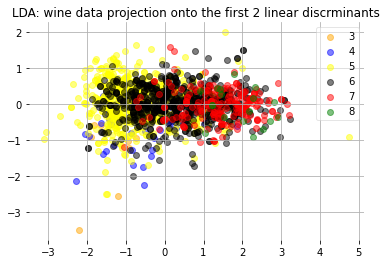

In [114]:
def plot_step_lda():
    fig=plt.figure()
    
    ax=plt.subplot(111)
    
    for label,color in zip(
        range(3,9),('orange','blue','yellow','black','red','green')):
        
        
        plt.scatter(x=x_lda[:,0].real[y == label],
            y=x_lda[:,1].real[y == label],
        
        
        color=color,
        alpha=0.5,
        label=label
                   )
        
    plt.xlabel=('Linear Discriminant 1')
    plt.xlabel=('Linear Discriminant 2')
    
    leg=plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: wine data projection onto the first 2 linear discrminants')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.grid()
    plt.show()
    
plot_step_lda()

### plot the dataset after performing PCA

In [115]:
pca = PCA(n_components=2)
x_pca=pca.fit_transform(x_std)

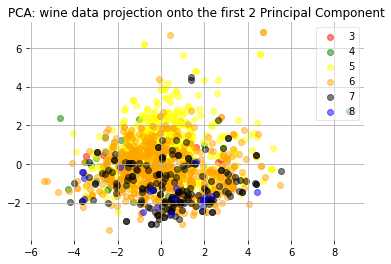

In [116]:
def plot_step_pca():
    fig=plt.figure()
    
    ax=plt.subplot(111)
    
    for label,color in zip(
        range(3,9),('red','green','yellow','orange','black','blue')):
        
        
        plt.scatter(x=x_pca[:,0].real[y == label],
            y=x_pca[:,1].real[y == label],
        
        
        color=color,
        alpha=0.5,
        label=label
                   )
        
    plt.xlabel=('Principal Component 1')
    plt.xlabel=('Principal Component 2')
    
    leg=plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: wine data projection onto the first 2 Principal Component')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.grid()
    plt.show()
    
plot_step_pca()

# Setting up the classfier to compare LDA v PCA

### split the dataset into training and testing part

Finshing the comparison between LDAnPCA using classfier imported from sklearn.svm import svc

In [117]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)


In [118]:
scaler = StandardScaler()
x_train=scaler.fit_transform(x_train) 
#.fit takes the dataset we aim to standradize as an argument and computes it's mean and std
x_test=scaler.transform(x_test)
# .transform applies the formula for every feature's value
# .fit_transform applied the two methods at the same time
# Data Leakage is when you try to relearn the mean and std in order to accuratley test the selected model for classification 

# coding the classfier for PCA and LDA

## perform LDA with 2 linear discrminant and store the results from the training and testing parts

In [119]:
lda = LDA(n_components=2)

In [120]:
x_train_lda =lda.fit_transform(x_train,y_train) # fitting the training data finds the 2 linear discrminant
# .Fit  finds the 2 linear discrminant
# .Transform projects the data
# and thus lower the dimension of our data

In [121]:
x_test_lda=lda.transform(x_test) # projects the data

## perform PCA with 2 Principal Components and store the results from the training and testing parts

In [122]:
pca=PCA(n_components=2)

In [123]:
x_train_pca=pca.fit_transform(x_train,y_train)

In [124]:
x_test_pca=pca.transform(x_test)

#### import the classifier

In [125]:
svclassifier=SVC(kernel='linear')

### Run the classifier through the LDA train and test sets and return the neccessary time for training and testing 

    Steps
    
        1) timing the code before and after training
       2) calculate the difference in order to get the training time
      3) follow the same procedure when testing time for both algorithm

In [134]:
def train_test_lda():
    time_for_train_test_lda=[]
    start_train_lda=time.time()
    svclassifier.fit(x_train_lda,y_train) # save the quality grade for the train set
    finish_train_lda=time.time()
    
    start_test_lda=time.time()
    y_pred_lda=svclassifier.predict(x_test_lda)
    finish_test_lda=time.time()
    
    time_for_train_test_lda.append(finish_train_lda - start_train_lda)
    time_for_train_test_lda.append(finish_test_lda - start_test_lda)
    time_for_train_test_lda.append(y_pred_lda)    
    
    return time_for_train_test_lda

### Run the classifier through the PCA train and test sets and return the neccessary time for training and testing 

In [140]:
def train_test_pca():
    time_for_train_test_pca=[]
    start_train_pca=time.time()
    svclassifier.fit(x_train_pca,y_train) # save the quality grade for the train set
    finish_train_pca=time.time()
    
    start_test_pca=time.time()
    y_pred_pca=svclassifier.predict(x_test_pca)
    finish_test_pca=time.time()
    
    time_for_train_test_pca.append(finish_train_pca - start_train_pca)
    time_for_train_test_pca.append(finish_test_pca - start_test_pca)
    time_for_train_test_pca.append(y_pred_pca)  
    
    return time_for_train_test_pca

# Analysis of the training and testing times for the classifiers and it's accuracy

In [141]:
train_lda=0
test_lda=0
for i in range(10):
    
    c=train_test_lda()
    train_lda+=c[0]
    test_lda+=c[1]
    
print('Average time for training out of 10 runs LDA:{}'.format(train_lda/10))
print('Average time for testing out of 10 runs LDA:{}'.format(test_lda/10))


Average time for training out of 10 runs LDA:0.06810050010681153
Average time for testing out of 10 runs LDA:0.008985352516174317


In [142]:
train_pca=0
test_pca=0
for i in range(10):
    
    m=train_test_pca()
    train_pca+=m[0]
    test_pca+=m[1]
    
print('Average time for training out of 10 runs PCA:{}'.format(train_pca/10))
print('Average time for testing out of 10 runs PCA:{}'.format(test_pca/10))

Average time for training out of 10 runs PCA:0.08644764423370362
Average time for testing out of 10 runs PCA:0.015708374977111816


### Measure the accuracy

In [159]:
a = train_test_lda()
b = train_test_pca()

#### before measure the accuracy we need to print out the confusion matrix for LDA

In [160]:
# Confussion matrix is a table that shows which wines were graded correctly and which were not 
# shows us the number of wines that we correctly identified in class 3, as well as the number of wines in class 3 which we misclassified
# we use confusion matrix because it help us improve our model by analyzing the misclassified data and adjusting parameters accordingly 
cm_lda=confusion_matrix(y_test,a[2])
print('confussion matrix for LDA:\n')
print(cm_lda)
print('\n')
print('LDA accuracy:'+' '+ str(accuracy_score(y_test,a[2])))

confussion matrix for LDA:

[[  0   0   2   0   0   0]
 [  0   0   6   5   0   0]
 [  0   0 107  28   0   0]
 [  0   0  45  97   0   0]
 [  0   0   1  26   0   0]
 [  0   0   0   3   0   0]]


LDA accuracy: 0.6375


In [161]:
cm_pca=confusion_matrix(y_test,b[2])
print('confussion matrix for PCA:\n')
print(cm_pca)
print('\n')
print('PCA accuracy:'+' '+ str(accuracy_score(y_test,b[2])))

confussion matrix for PCA:

[[ 0  0  0  2  0  0]
 [ 0  0  4  7  0  0]
 [ 0  0 87 48  0  0]
 [ 0  0 54 88  0  0]
 [ 0  0  4 23  0  0]
 [ 0  0  0  3  0  0]]


PCA accuracy: 0.546875
